In [1]:
# !pip install imbalanced-learn
# !sudo apt-get install -y fonts-nanum
# !sudo fc-cache -fv
# !rm ~/.cache/matplotlib -rf #폰트 다운로드 한 후 런타임 다시시작
# !pip install catboost

In [2]:
# 경고(warning) 비표시
import warnings
warnings.filterwarnings('ignore')
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style='whitegrid')

#한글폰트 나오게
plt.rc('font', family='NanumBarunGothic')
import matplotlib as mpl #음수 표기되게
mpl.rc('axes', unicode_minus=False)

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split

from sklearn.metrics import classification_report
from sklearn.ensemble import AdaBoostClassifier
from lightgbm import LGBMClassifier
from xgboost import XGBClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
import catboost as cb

from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler

from sklearn.metrics import roc_auc_score, auc, roc_curve, precision_score, recall_score, f1_score
from sklearn.metrics import accuracy_score
from sklearn.model_selection import cross_val_score

from tqdm import tqdm
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV

In [3]:
df = pd.read_csv('/content/train.csv')
df

,id,Gender,Age,Driving_License,Region_Code,Previously_Insured,Vehicle_Age,Vehicle_Damage,Annual_Premium,Policy_Sales_Channel,Vintage,Response
0,1,Male,44,1,28.0,0,> 2 Years,Yes,40454.0,26.0,217,1
1,2,Male,76,1,3.0,0,1-2 Year,No,33536.0,26.0,183,0
2,3,Male,47,1,28.0,0,> 2 Years,Yes,38294.0,26.0,27,1
3,4,Male,21,1,11.0,1,< 1 Year,No,28619.0,152.0,203,0
4,5,Female,29,1,41.0,1,< 1 Year,No,27496.0,152.0,39,0
...,...,...,...,...,...,...,...,...,...,...,...,...
381104,381105,Male,74,1,26.0,1,1-2 Year,No,30170.0,26.0,88,0
381105,381106,Male,30,1,37.0,1,< 1 Year,No,40016.0,152.0,131,0
381106,381107,Male,21,1,30.0,1,< 1 Year,No,35118.0,160.0,161,0
381107,381108,Female,68,1,14.0,0,> 2 Years,Yes,44617.0,124.0,74,0


# Encoding

Gender, Vehicle_Age, Vehicle_Damage => 인코딩

Region_Code, Annual_Premium, Policy_Sales_Channel => float-> int


In [4]:
encoder = LabelEncoder()
encoder.fit(df['Gender'])
df['Gender_Label_En'] = encoder.transform(df['Gender'])
df['Region_Code_re'] = df['Region_Code'].astype(int)
encoder.fit(df['Vehicle_Age'])
df['Vehicle_Age_Label_En'] = encoder.transform(df['Vehicle_Age'])
encoder.fit(df['Vehicle_Damage'])
df['Vehicle_Damage_Label_En'] = encoder.transform(df['Vehicle_Damage'])
df['Annual_Premium_re'] = df['Annual_Premium'].astype(int)
df['Policy_Sales_Channel_re'] = df['Policy_Sales_Channel'].astype(int)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 381109 entries, 0 to 381108
Data columns (total 18 columns):
 #   Column                   Non-Null Count   Dtype  
---  ------                   --------------   -----  
 0   id                       381109 non-null  int64  
 1   Gender                   381109 non-null  object 
 2   Age                      381109 non-null  int64  
 3   Driving_License          381109 non-null  int64  
 4   Region_Code              381109 non-null  float64
 5   Previously_Insured       381109 non-null  int64  
 6   Vehicle_Age              381109 non-null  object 
 7   Vehicle_Damage           381109 non-null  object 
 8   Annual_Premium           381109 non-null  float64
 9   Policy_Sales_Channel     381109 non-null  float64
 10  Vintage                  381109 non-null  int64  
 11  Response                 381109 non-null  int64  
 12  Gender_Label_En          381109 non-null  int64  
 13  Region_Code_re           381109 non-null  int64  
 14  Vehi

In [5]:
df.head()

,id,Gender,Age,Driving_License,Region_Code,Previously_Insured,Vehicle_Age,Vehicle_Damage,Annual_Premium,Policy_Sales_Channel,Vintage,Response,Gender_Label_En,Region_Code_re,Vehicle_Age_Label_En,Vehicle_Damage_Label_En,Annual_Premium_re,Policy_Sales_Channel_re
0,1,Male,44,1,28.0,0,> 2 Years,Yes,40454.0,26.0,217,1,1,28,2,1,40454,26
1,2,Male,76,1,3.0,0,1-2 Year,No,33536.0,26.0,183,0,1,3,0,0,33536,26
2,3,Male,47,1,28.0,0,> 2 Years,Yes,38294.0,26.0,27,1,1,28,2,1,38294,26
3,4,Male,21,1,11.0,1,< 1 Year,No,28619.0,152.0,203,0,1,11,1,0,28619,152
4,5,Female,29,1,41.0,1,< 1 Year,No,27496.0,152.0,39,0,0,41,1,0,27496,152


In [6]:
df.columns

Index(['id', 'Gender', 'Age', 'Driving_License', 'Region_Code',
       'Previously_Insured', 'Vehicle_Age', 'Vehicle_Damage', 'Annual_Premium',
       'Policy_Sales_Channel', 'Vintage', 'Response', 'Gender_Label_En',
       'Region_Code_re', 'Vehicle_Age_Label_En', 'Vehicle_Damage_Label_En',
       'Annual_Premium_re', 'Policy_Sales_Channel_re'],
      dtype='object')

In [7]:
X_data = df[['Gender_Label_En', 'Driving_License', 'Region_Code_re',
       'Previously_Insured', 'Vehicle_Age_Label_En', 'Vehicle_Damage_Label_En', 'Annual_Premium_re',
       'Policy_Sales_Channel_re', 'Vintage']]
y = df['Response']

In [8]:
X_data.shape, y.shape

((381109, 9), (381109,))

# Feature Engineering Age_GP_s
Age는 20대, 30대, 40대, 그이상 으로 범주화

## age 범주화

Age_GP_q  = 사분위로 나눔 

Age_GP_s  = 연령대로 나눔


In [9]:
# X_data['Age_GP_q'] = np.where (df['Age'] < 25, 1, 
#                            np.where(df['Age'] < 36, 2,
#                            np.where(df['Age'] < 49, 3, 4)))
# X_data.Age_GP_q.value_counts(), sorted(X_data.Age_GP_q.unique()), len(X_data.Age_GP_q.unique())

In [10]:
# sns.countplot(x=y, hue=X_data['Age_GP_q'], data=X_data, dodge=True, palette="pastel");
# plt.legend(labels = ['25미만', '36미만', '49미만', '49이상']);

In [11]:
X_data['Age_GP_s'] = np.where (df['Age'] < 30, 1, 
                           np.where(df['Age'] < 40, 2,
                           np.where(df['Age'] < 50, 3, 4)))
X_data.Age_GP_s.value_counts(), sorted(X_data.Age_GP_s.unique()), len(X_data.Age_GP_s.unique())

(1    155203
 4     94807
 3     76846
 2     54253
 Name: Age_GP_s, dtype: int64, [1, 2, 3, 4], 4)

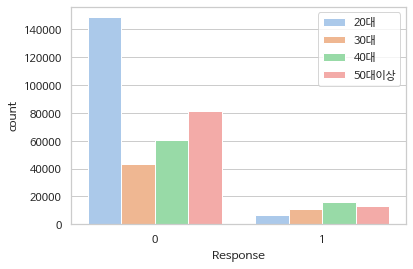

In [12]:
sns.countplot(x=y, hue=X_data['Age_GP_s'], data=X_data, dodge=True, palette="pastel");
plt.legend(labels = ['20대', '30대', '40대', '50대이상']);

### Age + Previously_Insured

In [13]:
X_data['age_PI'] = np.where ((X_data['Age_GP_s'] == 1) & (X_data['Previously_Insured'] == 0), 1,
                           np.where((X_data['Age_GP_s'] == 2) & (X_data['Previously_Insured'] == 0), 2, 
                           np.where((X_data['Age_GP_s'] == 3) & (X_data['Previously_Insured'] == 0), 3, 
                           np.where((X_data['Age_GP_s'] == 4) & (X_data['Previously_Insured'] == 0), 4, 5))))
                           
X_data['age_PI'].value_counts()

5    174628
4     63595
3     55887
1     53124
2     33875
Name: age_PI, dtype: int64

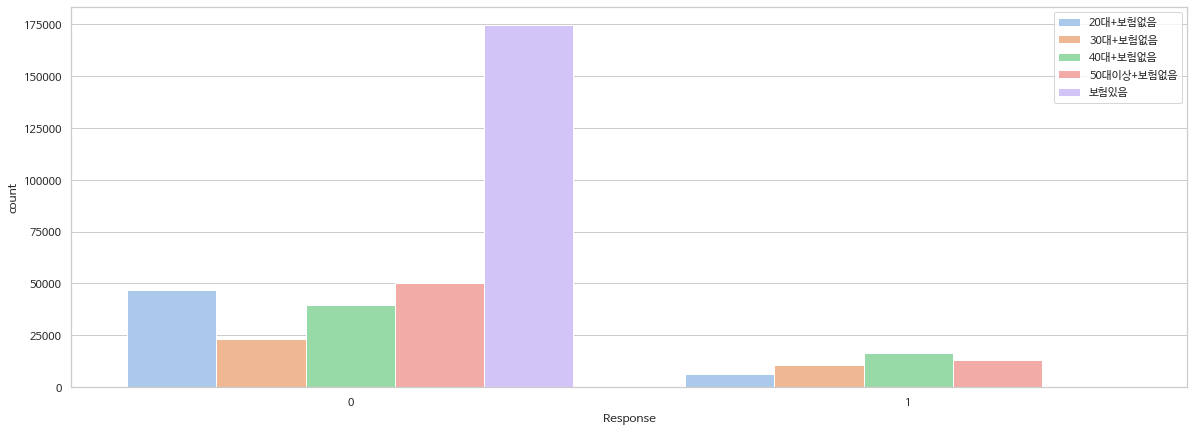

In [14]:
# response 0 = 관심x 
fig, ax = plt.subplots(figsize=(20,7))
sns.countplot(x=y, hue=X_data['age_PI'], data=X_data, ax=ax, palette="pastel");
plt.legend(labels = ['20대+보험없음', '30대+보험없음', '40대+보험없음', '50대이상+보험없음', '보험있음']);

### Age + Vehicle_Damage

In [15]:
# Vehicle_Damage_Label_En = 0 -> 사고 o
X_data['age_VD'] = np.where ((X_data['Age_GP_s'] == 1) & (X_data['Vehicle_Damage_Label_En'] == 1), 1,
                           np.where((X_data['Age_GP_s'] == 2) & (X_data['Vehicle_Damage_Label_En'] == 1), 2, 
                           np.where((X_data['Age_GP_s'] == 3) & (X_data['Vehicle_Damage_Label_En'] == 1), 3, 
                           np.where((X_data['Age_GP_s'] == 4) & (X_data['Vehicle_Damage_Label_En'] == 1), 4, 5))))
                           
X_data['age_VD'].value_counts()

5    188696
4     61383
3     52856
1     46743
2     31431
Name: age_VD, dtype: int64

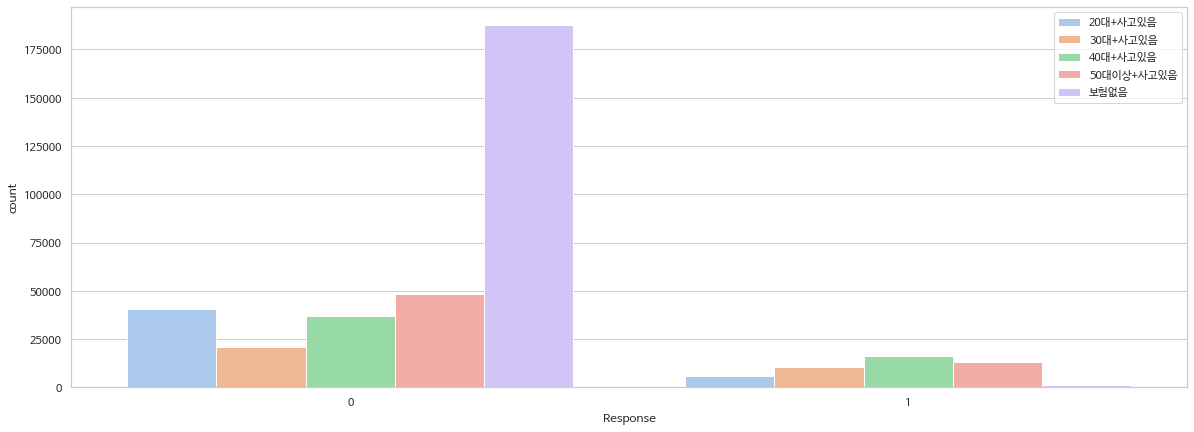

In [16]:
# response 0 = 관심x 
fig, ax = plt.subplots(figsize=(20,7))
sns.countplot(x=y, hue=X_data['age_VD'], data=X_data, ax=ax, palette="pastel");
plt.legend(labels = ['20대+사고있음', '30대+사고있음', '40대+사고있음', '50대이상+사고있음', '보험없음']);

### Age + Policy_Sales_Channel_re

In [17]:
# psc_GP age그룹별 판매채널 상위 5개 중 4개씩 나온 152, 124, 26 와 기타로 그룹화 
X_data['psc_GP'] = np.where (X_data['Policy_Sales_Channel_re'] == 152, 1, 
                           np.where(X_data['Policy_Sales_Channel_re'] == 124, 2,
                           np.where(X_data['Policy_Sales_Channel_re'] == 26, 3, 4)))
X_data['psc_GP'].value_counts()

1    134784
4     92630
3     79700
2     73995
Name: psc_GP, dtype: int64

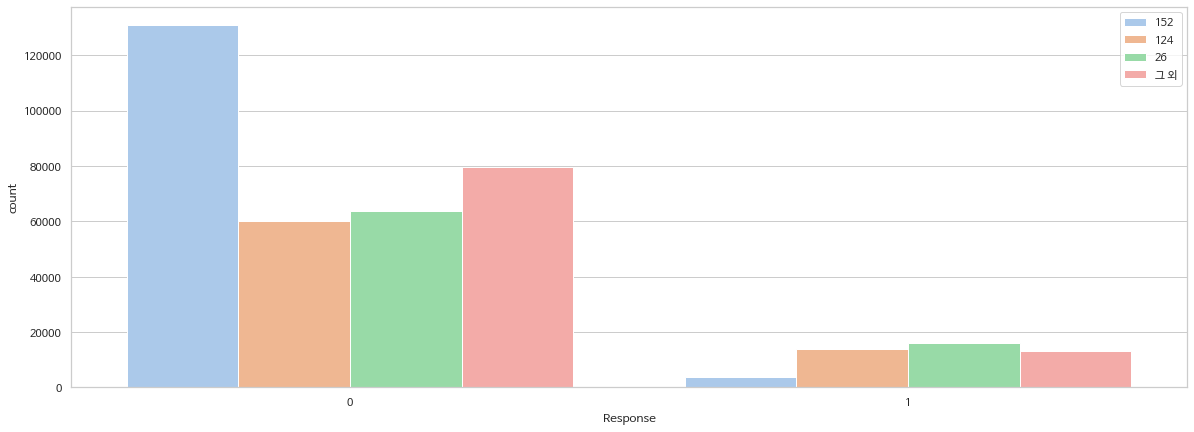

In [18]:
fig, ax = plt.subplots(figsize=(20,7))
sns.countplot(x=y, hue=X_data['psc_GP'], data=X_data, ax=ax, palette="pastel");
plt.legend(labels = ['152', '124', '26', '그 외']);

## Vehicle_Age + PI

In [19]:
# Previously_Insured 이전 보험 0 가입 안됨 / 1 가입 됨 이고 1은 거의 response 1 이기에  하나로 통합 
X_data['VA_PI'] = np.where ((X_data['Vehicle_Age_Label_En'] == 0) & (X_data['Previously_Insured'] == 0), 1,
                           np.where((X_data['Vehicle_Age_Label_En'] == 1) & (X_data['Previously_Insured'] == 0), 2,  
                           np.where((X_data['Vehicle_Age_Label_En'] == 2) & (X_data['Previously_Insured'] == 0), 3,4)))
                           
X_data['VA_PI'].value_counts()

4    174628
1    134991
2     55529
3     15961
Name: VA_PI, dtype: int64

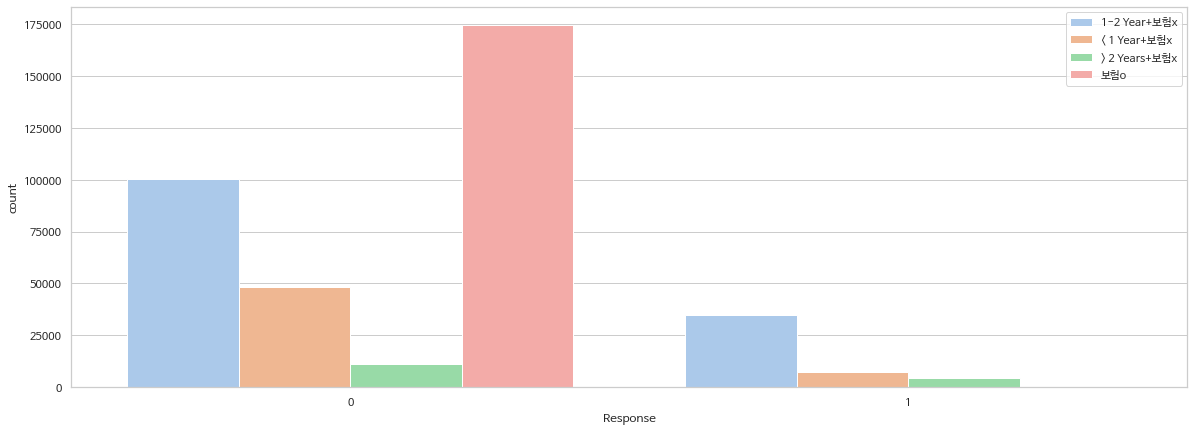

In [20]:
fig, ax = plt.subplots(figsize=(20,7))
sns.countplot(x=y, hue=X_data['VA_PI'], data=X_data, ax=ax, palette="pastel");
plt.legend(labels = ['1-2 Year+보험x', '< 1 Year+보험x', '> 2 Years+보험x', '보험o']);

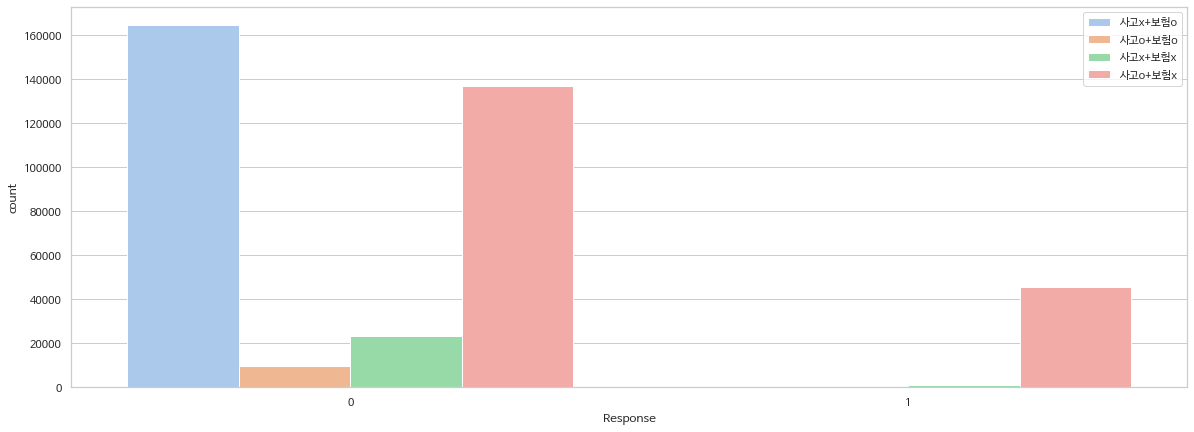

In [21]:
X_data['VD_PI'] = np.where((df['Vehicle_Damage_Label_En'] == 0) & (df['Previously_Insured'] == 1), 0,
                             np.where((df['Vehicle_Damage_Label_En'] == 1) & (df['Previously_Insured'] == 1), 1,
                                      np.where((df['Vehicle_Damage_Label_En'] == 0) & (df['Previously_Insured'] == 0), 2,
                                               np.where((df['Vehicle_Damage_Label_En'] == 1) & (df['Previously_Insured'] == 0), 3, -1))))
fig, ax = plt.subplots(figsize=(20,7))
sns.countplot(x=y, hue=X_data['VD_PI'], data=X_data, ax=ax, palette="pastel");
plt.legend(labels = ['사고x+보험o', '사고o+보험o', '사고x+보험x', '사고o+보험x']);
plt.savefig('VD_PI')

# 모델링

기존데이터 vs SMOTE vs UnderSampler 

세가지 방법 중 UnderSampler가 가장 좋은 성능을 보임

In [22]:
X_train, X_test, y_train, y_test = train_test_split(X_data, 
                                                    y, 
                                                    stratify=y,
                                                    test_size = 0.2)

# X_data_ch = X_data[['Vehicle_Damage_Label_En', 'Previously_Insured', 'VA_PI', 'age_VD', 'age_PI']]
# X_train, X_test, y_train, y_test = train_test_split(X_data_ch, 
#                                                     y, 
#                                                     stratify=y,
#                                                     test_size = 0.2)

## 기본 데이터

In [59]:
ABC = AdaBoostClassifier(random_state=42)
ABC.fit(X_train, y_train)

# ▶ 예측
ABC_y_pred_train = ABC.predict(X_train)
ABC_y_pred_test = ABC.predict(X_test)


In [31]:
LGBM = LGBMClassifier(random_state=42)
LGBM.fit(X_train, y_train)

# ▶ 예측
LGBM_y_pred_train = LGBM.predict(X_train)
LGBM_y_pred_test = LGBM.predict(X_test)


In [30]:
XGBC = XGBClassifier(random_state=42)
XGBC.fit(X_train, y_train)

# ▶ 예측
XGBC_y_pred_train = XGBC.predict(X_train)
XGBC_y_pred_test = XGBC.predict(X_test)


In [30]:
KN = KNeighborsClassifier()
KN.fit(X_train, y_train)

# ▶ 예측
KN_y_pred_train = KN.predict(X_train)
KN_y_pred_test = KN.predict(X_test)


In [31]:
MLP = MLPClassifier(random_state=42)
MLP.fit(X_train, y_train)

# ▶ 예측
MLP_y_pred_train = MLP.predict(X_train)
MLP_y_pred_test = MLP.predict(X_test)


In [33]:
RF = RandomForestClassifier(random_state=42)
RF.fit(X_train, y_train)

# ▶ 예측
RF_y_pred_train = RF.predict(X_train)
RF_y_pred_test = RF.predict(X_test)


In [35]:
GB = GradientBoostingClassifier(random_state=42)
GB.fit(X_train, y_train)

# ▶ 예측
GB_y_pred_train = GB.predict(X_train)
GB_y_pred_test = GB.predict(X_test)


In [ ]:
CAT_data = cb.Pool(data=X_train, label=y_train)

CAT = cb.CatBoostClassifier(random_state=42)
CAT.fit(CAT_data)

# ▶ 예측
CAT_y_pred_train = CAT.predict(X_train)
CAT_y_pred_test = CAT.predict(X_test)


### 모델 비교

In [61]:
precision = [precision_score(y_test, ABC_y_pred_test, pos_label=1),
             precision_score(y_test, LGBM_y_pred_test, pos_label=1),
             precision_score(y_test, XGBC_y_pred_test, pos_label=1),
             precision_score(y_test, KN_y_pred_test, pos_label=1),
             precision_score(y_test, MLP_y_pred_test, pos_label=1),
             precision_score(y_test, RF_y_pred_test, pos_label=1),
             precision_score(y_test, GB_y_pred_test, pos_label=1),
             precision_score(y_test, CAT_y_pred_test, pos_label=1)]


In [62]:
recall = [recall_score(y_test, ABC_y_pred_test, pos_label=1),
             recall_score(y_test, LGBM_y_pred_test, pos_label=1),
             recall_score(y_test, XGBC_y_pred_test, pos_label=1),
             recall_score(y_test, KN_y_pred_test, pos_label=1),
             recall_score(y_test, MLP_y_pred_test, pos_label=1),
             recall_score(y_test, RF_y_pred_test, pos_label=1),
             recall_score(y_test, GB_y_pred_test, pos_label=1),
             recall_score(y_test, CAT_y_pred_test, pos_label=1)]


In [63]:
f1_s = [f1_score(y_test, ABC_y_pred_test, pos_label=1),
             f1_score(y_test, LGBM_y_pred_test, pos_label=1),
             f1_score(y_test, XGBC_y_pred_test, pos_label=1),
             f1_score(y_test, KN_y_pred_test, pos_label=1),
             f1_score(y_test, MLP_y_pred_test, pos_label=1),
             f1_score(y_test, RF_y_pred_test, pos_label=1),
             f1_score(y_test, GB_y_pred_test, pos_label=1),
             f1_score(y_test, CAT_y_pred_test, pos_label=1)]

In [64]:
base_score_df = pd.DataFrame([precision, recall, f1_s], 
                        columns=['ABC', 'LGBM', 'XGBC', 'KN', 'MLP', 'RF', 'GB', 'CAT'],
                        index=['precision', 'recall', 'f1_score'])

In [65]:
base_score_df = base_score_df.T
base_score_df

,precision,recall,f1_score
ABC,0.250000,0.000107,0.000214
LGBM,0.130435,0.000642,0.001278
XGBC,0.102397,0.005031,0.009591
KN,0.119499,0.033719,0.052596
MLP,0.123280,0.487155,0.196766
RF,0.121737,0.059409,0.079850
GB,0.000000,0.000000,0.000000
CAT,0.132931,0.009420,0.017593


In [66]:
base_score_df.to_csv("base_score_df.csv", mode='w')

## SMOTE

In [51]:
smote = SMOTE(random_state=42)
X_train_over, y_train_over = smote.fit_resample(X_train, y_train)
print("SMOTE 적용 전 학습용 피처/레이블 데이터 세트 : ", X_train.shape, y_train.shape)
print('SMOTE 적용 후 학습용 피처/레이블 데이터 세트 :', X_train_over.shape, y_train_over.shape)
print('SMOTE 적용 후 값의 분포 :\n',pd.Series(y_train_over).value_counts() )

SMOTE 적용 전 학습용 피처/레이블 데이터 세트 :  (304887, 15) (304887,)
SMOTE 적용 후 학습용 피처/레이블 데이터 세트 : (535038, 15) (535038,)
SMOTE 적용 후 값의 분포 :
 0    267519
1    267519
Name: Response, dtype: int64


In [68]:
ABC_over = AdaBoostClassifier(random_state=42)
ABC_over.fit(X_train_over, y_train_over)

# ▶ 예측
ABC_over_y_pred_train = ABC_over.predict(X_train_over)
ABC_over_y_pred_test = ABC_over.predict(X_test)


In [37]:
LGBM_over = LGBMClassifier(random_state=42)
LGBM_over.fit(X_train_over, y_train_over)

# ▶ 예측
LGBM_over_y_pred_train = LGBM_over.predict(X_train_over)
LGBM_over_y_pred_test = LGBM_over.predict(X_test)


In [38]:
XGBC_over = XGBClassifier(random_state=42)
XGBC_over.fit(X_train_over, y_train_over)

# ▶ 예측
XGBC_over_y_pred_train = XGBC_over.predict(X_train_over)
XGBC_over_y_pred_test = XGBC_over.predict(X_test)


In [71]:
KN_over = KNeighborsClassifier()
KN_over.fit(X_train_over, y_train_over)

# ▶ 예측
KN_over_y_pred_train = KN_over.predict(X_train_over)
KN_over_y_pred_test = KN_over.predict(X_test)


In [72]:
MLP_over = MLPClassifier(random_state=42)
MLP_over.fit(X_train_over, y_train_over)

# ▶ 예측
MLP_over_y_pred_train = MLP_over.predict(X_train_over)
MLP_over_y_pred_test = MLP_over.predict(X_test)


In [ ]:
RF_over = RandomForestClassifier(random_state=42)
RF_over.fit(X_train_over, y_train_over)

# ▶ 예측
RF_over_y_pred_train = RF_over.predict(X_train_over)
RF_over_y_pred_test = RF_over.predict(X_test)


In [ ]:
GB_over = GradientBoostingClassifier(random_state=42)
GB_over.fit(X_train_over, y_train_over)

# ▶ 예측
GB_over_y_pred_train = GB_over.predict(X_train_over)
GB_over_y_pred_test = GB_over.predict(X_test)


In [ ]:
CAT_data = cb.Pool(data=X_train_over, label=y_train_over)

CAT_over = cb.CatBoostClassifier(random_state=42)
CAT_over.fit(CAT_data)

# ▶ 예측
CAT_over_y_pred_train = CAT_over.predict(X_train_over)
CAT_over_y_pred_test = CAT_over.predict(X_test)


### 모델 비교

In [ ]:
precision_over = [precision_score(y_test, ABC_over_y_pred_test, pos_label=1),
             precision_score(y_test, LGBM_over_y_pred_test, pos_label=1),
             precision_score(y_test, XGBC_over_y_pred_test, pos_label=1),
             precision_score(y_test, KN_over_y_pred_test, pos_label=1),
             precision_score(y_test, MLP_over_y_pred_test, pos_label=1),
             precision_score(y_test, RF_over_y_pred_test, pos_label=1),
             precision_score(y_test, GB_over_y_pred_test, pos_label=1),
             precision_score(y_test, CAT_over_y_pred_test, pos_label=1)]

In [ ]:
recall_over = [recall_score(y_test, ABC_over_y_pred_test, pos_label=1),
             recall_score(y_test, LGBM_over_y_pred_test, pos_label=1),
             recall_score(y_test, XGBC_over_y_pred_test, pos_label=1),
             recall_score(y_test, KN_over_y_pred_test, pos_label=1),
             recall_score(y_test, MLP_over_y_pred_test, pos_label=1),
             recall_score(y_test, RF_over_y_pred_test, pos_label=1),
             recall_score(y_test, GB_over_y_pred_test, pos_label=1),
             recall_score(y_test, CAT_over_y_pred_test, pos_label=1)]

In [ ]:
f1_score_over = [f1_score(y_test, ABC_over_y_pred_test, pos_label=1),
             f1_score(y_test, LGBM_over_y_pred_test, pos_label=1),
             f1_score(y_test, XGBC_over_y_pred_test, pos_label=1),
             f1_score(y_test, KN_over_y_pred_test, pos_label=1),
             f1_score(y_test, MLP_over_y_pred_test, pos_label=1),
             f1_score(y_test, RF_over_y_pred_test, pos_label=1),
             f1_score(y_test, GB_over_y_pred_test, pos_label=1),
             f1_score(y_test, CAT_over_y_pred_test, pos_label=1)]

In [ ]:
over_score_df = pd.DataFrame([precision_over, recall_over, f1_score_over], 
                        columns=['ABC', 'LGBM', 'XGBC', 'KN', 'MLP', 'RF', 'GB', 'CAT'],
                        index=['precision_over', 'recall_over', 'f1_score_over'])

In [ ]:
over_score_df = over_score_df.T
over_score_df

In [ ]:
over_score_df.to_csv("over_score_df.csv", mode='w')

## RandomUnderSampler

In [43]:
undersample = RandomUnderSampler(sampling_strategy='majority')
X_under, y_under = undersample.fit_resample(X_train, y_train)

In [ ]:
ABC_under = AdaBoostClassifier(random_state=42)
ABC_under.fit(X_under, y_under)

# ▶ 예측
ABC_under_y_pred_train = ABC_under.predict(X_under)
ABC_under_y_pred_test = ABC_under.predict(X_test)

In [44]:
LGBM_under = LGBMClassifier(random_state=42)
LGBM_under.fit(X_under, y_under)

# ▶ 예측
LGBM_under_y_pred_train = LGBM_under.predict(X_under)
LGBM_under_y_pred_test = LGBM_under.predict(X_test)

In [45]:
XGBC_under = XGBClassifier(random_state=42)
XGBC_under.fit(X_under, y_under)

# ▶ 예측
XGBC_under_y_pred_train = XGBC_under.predict(X_under)
XGBC_under_y_pred_test = XGBC_under.predict(X_test)

In [ ]:
KN_under = KNeighborsClassifier()
KN_under.fit(X_under, y_under)

# ▶ 예측
KN_under_y_pred_train = KN_under.predict(X_under)
KN_under_y_pred_test = KN_under.predict(X_test)

In [ ]:
MLP_under = MLPClassifier(random_state=42)
MLP_under.fit(X_under, y_under)

# ▶ 예측
MLP_under_y_pred_train = MLP_under.predict(X_under)
MLP_under_y_pred_test = MLP_under.predict(X_test)

In [ ]:
RF_under = RandomForestClassifier(random_state=42)
RF_under.fit(X_under, y_under)

# ▶ 예측
RF_under_y_pred_train = RF_under.predict(X_under)
RF_under_y_pred_test = RF_under.predict(X_test)

In [ ]:
GB_under = GradientBoostingClassifier(random_state=42)
GB_under.fit(X_under, y_under)

# ▶ 예측
GB_under_y_pred_train = GB_under.predict(X_under)
GB_under_y_pred_test = GB_under.predict(X_test)

In [ ]:
CAT_under_data = cb.Pool(data=X_under, label=y_under)

CAT_under = cb.CatBoostClassifier(random_state=42)
CAT_under.fit(CAT_under_data)

# ▶ 예측
CAT_under_y_pred_train = CAT_under.predict(X_under)
CAT_under_y_pred_test = CAT_under.predict(X_test)

### 모델 비교

In [ ]:
precision_under = [precision_score(y_test, ABC_under_y_pred_test, pos_label=1),
             precision_score(y_test, LGBM_under_y_pred_test, pos_label=1),
             precision_score(y_test, XGBC_under_y_pred_test, pos_label=1),
             precision_score(y_test, KN_under_y_pred_test, pos_label=1),
             precision_score(y_test, MLP_under_y_pred_test, pos_label=1),
             precision_score(y_test, RF_under_y_pred_test, pos_label=1),
             precision_score(y_test, GB_under_y_pred_test, pos_label=1),
             precision_score(y_test, CAT_under_y_pred_test, pos_label=1)]
recall_under = [recall_score(y_test, ABC_under_y_pred_test, pos_label=1),
             recall_score(y_test, LGBM_under_y_pred_test, pos_label=1),
             recall_score(y_test, XGBC_under_y_pred_test, pos_label=1),
             recall_score(y_test, KN_under_y_pred_test, pos_label=1),
             recall_score(y_test, MLP_under_y_pred_test, pos_label=1),
             recall_score(y_test, RF_under_y_pred_test, pos_label=1),
             recall_score(y_test, GB_under_y_pred_test, pos_label=1),
             recall_score(y_test, CAT_under_y_pred_test, pos_label=1)]
f1_score_under = [f1_score(y_test, ABC_under_y_pred_test, pos_label=1),
             f1_score(y_test, LGBM_under_y_pred_test, pos_label=1),
             f1_score(y_test, XGBC_under_y_pred_test, pos_label=1),
             f1_score(y_test, KN_under_y_pred_test, pos_label=1),
             f1_score(y_test, MLP_under_y_pred_test, pos_label=1),
             f1_score(y_test, RF_under_y_pred_test, pos_label=1),
             f1_score(y_test, GB_under_y_pred_test, pos_label=1),
             f1_score(y_test, CAT_under_y_pred_test, pos_label=1)]

In [ ]:
under_score_df = pd.DataFrame([precision_under, recall_under, f1_score_under], 
                        columns=['ABC', 'LGBM', 'XGBC', 'KN', 'MLP', 'RF', 'GB', 'CAT'],
                        index=['precision_under', 'recall_under', 'f1_score_under'])

In [ ]:
under_score_df = under_score_df.T
under_score_df

In [ ]:
under_score_df.to_csv("under_score_df.csv", mode='w')

# 모델 고르기

In [ ]:
scores_df = pd.concat([base_score_df, over_score_df, under_score_df], axis=1)
# over_score_df
# under_score_df
scores_df.to_csv("scores_df.csv", mode='w')

In [93]:
scores_df

,precision,recall,f1_score,precision_over,recall_over,f1_score_over,precision_under,recall_under,f1_score_under
ABC,0.400000,0.000214,0.000428,0.296286,0.677157,0.412211,0.276112,0.927317,0.425523
LGBM,0.393939,0.001392,0.002773,0.326672,0.566902,0.414495,0.277072,0.934489,0.427417
XGBC,0.421594,0.017555,0.033707,0.327156,0.549882,0.410238,0.278329,0.922608,0.427646
KN,0.215354,0.057054,0.090209,0.179553,0.469064,0.259697,0.168555,0.619461,0.265003
MLP,0.280936,0.008992,0.017426,0.257583,0.722650,0.379792,0.275838,0.210554,0.238815
RF,0.338688,0.164740,0.221662,0.320385,0.435239,0.369083,0.278977,0.842218,0.419124
GB,0.500000,0.000321,0.000642,0.318740,0.621923,0.421473,0.274594,0.937594,0.424782
CAT,0.477099,0.026761,0.050679,0.329370,0.536716,0.408223,0.278783,0.925070,0.428447


# scores

In [23]:
# scores_df = pd.read_csv('/content/scores_df.csv', index_col ='Unnamed: 0')
# scores_df

,precision,recall,f1_score,precision_over,recall_over,f1_score_over,precision_under,recall_under,f1_score_under
ABC,0.400000,0.000214,0.000428,0.296286,0.677157,0.412211,0.276112,0.927317,0.425523
LGBM,0.393939,0.001392,0.002773,0.326672,0.566902,0.414495,0.277072,0.934489,0.427417
XGBC,0.421594,0.017555,0.033707,0.327156,0.549882,0.410238,0.278329,0.922608,0.427646
KN,0.215354,0.057054,0.090209,0.179553,0.469064,0.259697,0.168555,0.619461,0.265003
MLP,0.280936,0.008992,0.017426,0.257583,0.722650,0.379792,0.275838,0.210554,0.238815
RF,0.338688,0.164740,0.221662,0.320385,0.435239,0.369083,0.278977,0.842218,0.419124
GB,0.500000,0.000321,0.000642,0.318740,0.621923,0.421473,0.274594,0.937594,0.424782
CAT,0.477099,0.026761,0.050679,0.329370,0.536716,0.408223,0.278783,0.925070,0.428447


In [ ]:
precisions = scores_df[['precision', 'precision_over', 'precision_under']]
recalls = scores_df[['recall', 'recall_over', 'recall_under']]
f1_scores = scores_df[['f1_score', 'f1_score_over', 'f1_score_under']]

# cv

### grid cv

In [ ]:
hps = [
    (
        RandomForestClassifier(random_state=0),
        {'n_estimators': [100,200,300],
         'max_depth': [None,3,4,5],}
    ),
    (
        GradientBoostingClassifier(random_state=0),
        {'loss' : ["deviance"],
         'n_estimators' : [100],
         'learning_rate': [0.1, 0.05, 0.01],
         'max_depth': [4],
         'min_samples_leaf': [100,150],
         'max_features': [0.3, 0.1]}
    ),
    (
        LGBMClassifier(random_state=0),
        {'n_estimators': [100, 200, 300],
         'learning_rate': [1, 0.1, 0.01],
          'max_depth': [None,3,4,5]}
    )
]

for hp, param_grid in tqdm(hps):
    rand_search = GridSearchCV(hp, param_grid, n_iter=5, scoring='roc_auc', 
                                     cv=3, random_state=0, n_jobs=-1)
    rand_search.fit(X_under, y_under)
    hp_name = type(hp).__name__
    hp_score = rand_search.score(X_test, y_test)
    print('최적 하이퍼 파라미터: ', rand_search.best_params_)
    print('최고 예측 정확도: {:.4f}'.format(rand_search.best_score_))

### random cv

In [ ]:
hps = [
    (
        XGBClassifier(random_state=0),
        {'min_child_weight' : [1, 3, 5],
         'n_estimators' : [250, 300, 350],
         'learning_rate': [1, 0.1, 0.01],
         'max_depth': [None,3,4,5],
         'reg_alpha': [0, 0.01, 0.001]}
    ),
    (
        cb.CatBoostClassifier(random_state=0),
        {
         'learning_rate': [0.1, 0.2, 0.3],
         'max_depth': [5, 7, 9],
         'l2_leaf_reg': [1, 3, 5, 7, 9],
         'random_strength': [1, 10, 100]}
    ),
    (
        LGBMClassifier(random_state=0),
        {'n_estimators': [100, 200, 300],
         'learning_rate': [1, 0.1, 0.01],
          'max_depth': [None,3,4,5]}
    )
     
]
for hp, param_grid in tqdm(hps):
    rand_search = RandomizedSearchCV(hp, param_grid, n_iter=5, scoring='roc_auc', 
                                     cv=3, random_state=0, n_jobs=-1)
    rand_search.fit(X_under, y_under)
    hp_name = type(hp).__name__
    hp_score = rand_search.score(X_test, y_test)
    print('최적 하이퍼 파라미터: ', rand_search.best_params_)
    print('최고 예측 정확도: {:.4f}'.format(rand_search.best_score_))

In [ ]:
# 최적 하이퍼 파라미터:  {'reg_alpha': 0.001, 'n_estimators': 300, 'min_child_weight': 1, 'max_depth': 3, 'learning_rate': 0.1}
rand_XGBC_under = XGBClassifier(reg_alpha=0.001, n_estimators=300, min_child_weight=1, max_depth=3, learning_rate=0.1, random_state=42)
rand_XGBC_under.fit(X_under, y_under)

# ▶ 예측
rand_XGBC_under_y_pred_train = rand_XGBC_under.predict(X_under)
rand_XGBC_under_y_pred_test = rand_XGBC_under.predict(X_test)

In [ ]:
# 최적 하이퍼 파라미터:  {'random_strength': 100, 'max_depth': 5, 'learning_rate': 0.1, 'l2_leaf_reg': 7}
rand_CAT_under = cb.CatBoostClassifier(random_strength=100, max_depth=5, learning_rate=0.1, l2_leaf_reg=7, random_state=42)
rand_CAT_under.fit(CAT_under_data)

# ▶ 예측
rand_CAT_under_y_pred_train = rand_CAT_under.predict(X_under)
rand_CAT_under_y_pred_test = rand_CAT_under.predict(X_test)

In [ ]:
# 최적 하이퍼 파라미터:  {'n_estimators': 200, 'max_depth': 3, 'learning_rate': 0.1}
rand_LGBM = LGBMClassifier(n_estimators=200, max_depth=3, learning_rate=0.1, random_state=42)
rand_LGBM.fit(X_under, y_under)

# ▶ 예측
rand_LGBM_y_pred_train = rand_LGBM.predict(X_under)
rand_LGBM_y_pred_test = rand_LGBM.predict(X_test)

# 모델 고르기

만들어 둔 모델들의 precision	recall	f1_score 값을 비교하여 각각 가장 높은 성능을 보이는 모델을 선택 

In [24]:
precision_hp = [
             precision_score(y_test, rand_XGBC_under_y_pred_test, pos_label=1),
             precision_score(y_test, rand_CAT_under_y_pred_test, pos_label=1),
             precision_score(y_test, rand_LGBM_y_pred_test, pos_label=1)]
recall_hp = [
             recall_score(y_test, rand_XGBC_under_y_pred_test, pos_label=1),
             recall_score(y_test, rand_CAT_under_y_pred_test, pos_label=1),
             recall_score(y_test, rand_LGBM_y_pred_test, pos_label=1)]
f1_score_hp = [
             f1_score(y_test, rand_XGBC_under_y_pred_test, pos_label=1),
             f1_score(y_test, rand_CAT_under_y_pred_test, pos_label=1),
             f1_score(y_test, rand_LGBM_y_pred_test, pos_label=1)]

              precision    recall  f1-score   support

           0       0.99      0.66      0.79     66880
           1       0.28      0.93      0.43      9342

    accuracy                           0.70     76222
   macro avg       0.63      0.80      0.61     76222
weighted avg       0.90      0.70      0.75     76222



In [ ]:
hp_score_df = pd.DataFrame([precision_hp, recall_hp, f1_score_hp], 
                        columns=['rand_XGBC', 'rand_CAT', 'rand_LGBM'],
                        index=['precision', 'recall', 'f1_score'])

In [ ]:
fig, ax = plt.subplots(figsize=(15,5))
sns.lineplot(data = hp_score_df, markers=True).set(title='precision_hp, recall_hp, f1_score_hp');
plt.savefig('hp_score_df')

# feature importances

In [ ]:
ftr_importances_values = rand_XGBC_under.feature_importances_
ftr_importances = pd.Series(ftr_importances_values, index = X_under.columns)
ftr_top5 = ftr_importances.sort_values(ascending=False)[:5]

plt.figure(figsize=(8,6))
plt.title('rand_XGBC model Feature Importances')
sns.barplot(x=ftr_top5, y=ftr_top5.index, palette="pastel")
plt.rc('xtick', labelsize=5)


In [ ]:
ftr_importances_values = rand_CAT_under.feature_importances_
ftr_importances = pd.Series(ftr_importances_values, index = X_under.columns)
ftr_top5 = ftr_importances.sort_values(ascending=False)[:5]

plt.figure(figsize=(10,5))
plt.title('rand_CAT_under model Feature Importances')
sns.barplot(x=ftr_top5, y=ftr_top5.index, palette="pastel")
plt.rc('xtick', labelsize=5)
plt.show()

In [ ]:
ftr_importances_values = rand_LGBM.feature_importances_
ftr_importances = pd.Series(ftr_importances_values, index = X_under.columns)
ftr_top5 = ftr_importances.sort_values(ascending=False)[:5]

plt.figure(figsize=(8,6))
plt.title('rand_LGBM model Feature Importances')
sns.barplot(x=ftr_top5, y=ftr_top5.index, palette="pastel")
plt.rc('xtick', labelsize=5)
plt.show()

# 성능높이기

## 스케일링

하지 않은 데이터와 큰 차이 없음 



In [ ]:
#스탠다드 스케일러
from sklearn.preprocessing import StandardScaler

X_scaler = StandardScaler()
scaled_X_train = X_scaler.fit_transform(X_under)
scaled_X_test = X_scaler.transform(X_test)
print(scaled_X_train.shape)
print(scaled_X_test.shape)

In [ ]:
scaled_hy_RF = RandomForestClassifier(max_depth=5, n_estimators=300)
scaled_hy_RF.fit(scaled_X_train, y_under)

# ▶ 예측
scaled_hy_RF_y_pred_train = scaled_hy_RF.predict(scaled_X_train)
scaled_hy_RF_y_pred_test = scaled_hy_RF.predict(scaled_X_test)

print(classification_report(y_under, hy_RF_y_pred_train))
print(classification_report(y_test, hy_RF_y_pred_test))

In [ ]:
print(recall_score(y_test, scaled_hy_RF_y_pred_test, pos_label=1))

In [ ]:
print(precision_score(y_test, scaled_hy_RF_y_pred_test, pos_label=1))

In [ ]:
print(f1_score(y_test, scaled_hy_RF_y_pred_test, pos_label=1))

In [ ]:
ftr_importances_values = scaled_hy_RF.feature_importances_
ftr_importances = pd.Series(ftr_importances_values, index = X_under.columns)
ftr_top10 = ftr_importances.sort_values(ascending=False)[:10]

plt.figure(figsize=(8,6))
plt.title('scaled_hy_RF model Feature Importances')
sns.barplot(x=ftr_top10, y=ftr_top10.index, palette="pastel")
plt.rc('xtick', labelsize=5)
plt.show()